<a href="https://colab.research.google.com/github/johnjosephcijin/mywork/blob/main/LangGraph_exmp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 641.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/

In [5]:
from typing import Annotated
from typing_extensions import TypedDict

In [8]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.5 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=8a9f102d90930d80a58a0b7ca0a7c916132646c1ae328d234a144e68eda98363
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=e59f1fc8e08016d0d0154a83872b52e3e6b91477554a94f3848077ec73208a67
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [32]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun


In [33]:
#Tools
arxiv_wrapper=ArxivAPIWrapper(top_k=2,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)



wikipedia_wrapper=WikipediaAPIWrapper(top_k=2,doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)
#

In [34]:
tools=[wikipedia_tool]

In [35]:
##LangGraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
    query: Annotated[list,add_messages]

In [17]:
from langgraph.graph import StateGraph,START,END

In [36]:
graphbuilder = StateGraph(State)


In [37]:
from langchain_groq import ChatGroq

In [38]:
from google.colab import userdata

groq_api_key = userdata.get('groq_api_key')

In [39]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma1-9b-IT")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x792a621e81c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x792a620b83d0>, model_name='Gemma1-9b-IT', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [40]:
tools_llm= llm.bind_tools(tools=tools)

In [41]:
def chatbot(state:State):
  return {"messages":[tools_llm.invoke(state["messages"])]}


In [42]:
from langgraph.prebuilt import ToolNode,tools_condition

In [43]:
graphbuilder.add_node("chatbot",chatbot)
graphbuilder.add_edge(START,"chatbot")
tool_node=ToolNode(tools=tools)
graphbuilder.add_node("tool_node",tool_node)
graphbuilder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graphbuilder.add_edge("tool_node","chatbot")
graphbuilder.add_edge("chatbot",END)


In [44]:
graph= graphbuilder.compile()

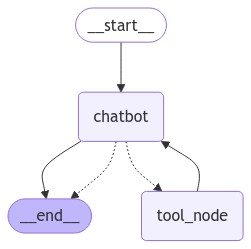

In [45]:
from IPython.display import display, Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [55]:
user_input = "Hello, My name is Cijin"

events = graph.stream(
    {"messages": [("user",user_input)]},stream_mode="values"

)

In [56]:
for event in events:
  event["messages"][-1].pretty_print()

InvalidUpdateError: Must write to at least one of ['query']